# How to backtest a multi-timeframe strategy

Multi-timeframe (MTF) analysis is an essential trading approach that involves analyzing an asset's price in different timeframes.

Despite its popularity, MTF analysis comes with several pitfalls when working with arrays, including look-ahead bias and information loss.

Many native pandas implementations mistakenly assume that events, such as indicator calculations, take place at the same timestamp as the data provided by the exchange, which is typically the opening time of a bar.

VBT operates under the assumption that the exact timing of most events is unknown and occurs at some point between the opening (best-case) and closing (worst-case) times of a bar. Consequently, VBT employs a set of features designed to resample data in the most sensitive way, without looking into the future.

In today's newsletter, we'll use VectorBT PRO to backtest trading on multiple timeframes simultaneously.

## Imports and set up

In the newer versions of VBT PRO, the star-import (*) loads all the relevant stuff for us, such as `np` for NumPy.

In [1]:
from vectorbtpro import *

Configure our graphs to be dark and gap-free.

In [2]:
vbt.settings.set_theme("dark")
vbt.settings.plotting.auto_rangebreaks = True

Grab the data of a higher frequency for your favorite asset. We'll use hourly TSLA.

In [3]:
data = vbt.YFData.pull("TSLA", start="2023", end="2024", timeframe="hourly")

## Multi-timeframe indicators

Instruct VBT to calculate the fast and slow SMA indicators across multiple timeframes.

Under the hood, data is first resampled to the target timeframe; then, the actual TA-Lib indicator is applied exclusively to non-missing values. Finally, the result is realigned back to the original timeframe in a manner that eliminates the possibility of look-ahead bias.

In [4]:
fast_sma = data.run(
    "talib:sma", 
    timeframe=["1h", "4h", "1d"], 
    timeperiod=vbt.Default(20),
    skipna=True
)
slow_sma = data.run(
    "talib:sma", 
    timeframe=["1h", "4h", "1d"], 
    timeperiod=vbt.Default(50),
    skipna=True
)

The result of each call is a DataFrame with three columns, one for each timeframe.

If we plot the DataFrame, we'll observe that the line corresponding to the highest frequency is smooth, whereas the line representing the lowest frequency appears stepped since the indicator values are updated less frequently.

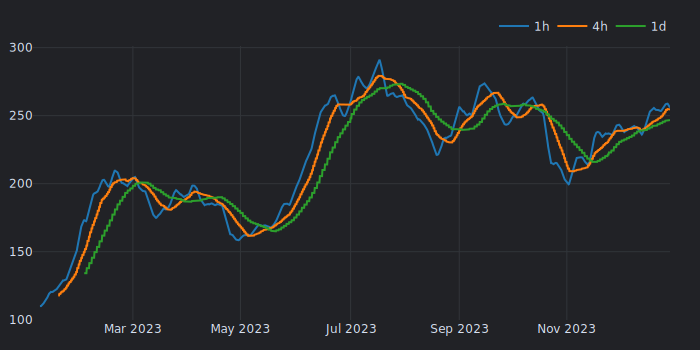

In [5]:
fast_sma.real.vbt.plot().show_svg()

## Unified portfolio

Next, we'll set up a portfolio in which we go long whenever the fast SMA crosses above the slow SMA and go short when the opposite occurs, across each timeframe.

However, since hourly signals occur more frequently than daily signals, we'll allocate less capital to more frequent signals. For instance, we'll allocate 5% of the equity to hourly signals, 10% to 4-hour signals, and 20% to daily signals.

We'll begin with a cash balance of $10,000, shared across all timeframes. Additionally, we'll implement a 20% trailing stop loss (TSL).

In [6]:
pf = vbt.PF.from_signals(
    data, 
    long_entries=fast_sma.real_crossed_above(slow_sma), 
    short_entries=fast_sma.real_crossed_below(slow_sma), 
    size=[[0.05, 0.1, 0.2]],
    size_type="valuepercent",
    init_cash=10_000,
    group_by=["pf", "pf", "pf"],
    cash_sharing=True,
    tsl_stop=0.2
)

Plot the cumulative return for each timeframe and compare these to the cumulative return of the entire portfolio.

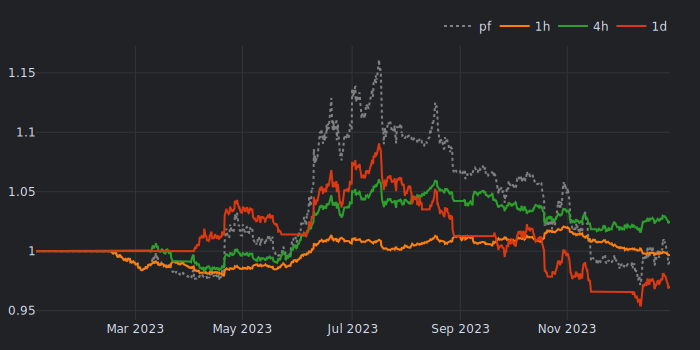

In [7]:
fig = pf.get_cumulative_returns().vbt.plot(trace_kwargs=dict(line_color="gray", line_dash="dot"))
fig = pf.get_cumulative_returns(group_by=False).vbt.plot(fig=fig)
fig.show_svg()

To delve deeper into one of the timeframes, we can plot the indicators alongside the executed trade signals.

Here, we can observe that the majority of positions on the daily timeframe were closed out by the TSL.

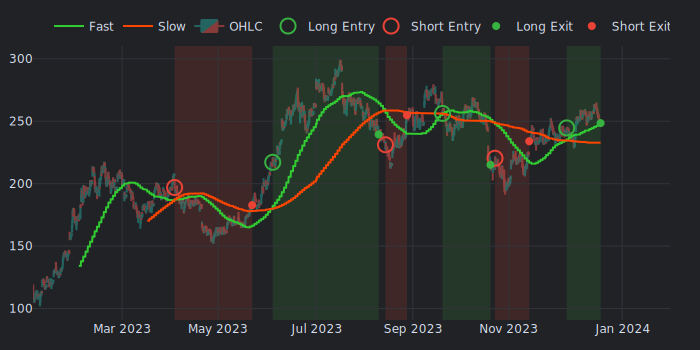

In [8]:
fig = fast_sma.real.vbt.plot(column="1d", trace_kwargs=dict(name="Fast", line_color="limegreen"))
fig = slow_sma.real.vbt.plot(column="1d", trace_kwargs=dict(name="Slow", line_color="orangered"), fig=fig)
fig = pf.plot_trade_signals(column="1d", fig=fig)
fig.show_svg()

## Timeframe product

Since our MTF indicators share the same index, we can combine one timeframe with another. For instance, we can generate signals from the crossover of two timeframes and identify the pair of timeframes that yield the highest expectancy.

In [9]:
fast_sma_real = fast_sma.real.vbt.rename_levels({"sma_timeframe": "fast_sma_timeframe"})
slow_sma_real = slow_sma.real.vbt.rename_levels({"sma_timeframe": "slow_sma_timeframe"})
fast_sma_real, slow_sma_real = fast_sma_real.vbt.x(slow_sma_real)
long_entries = fast_sma_real.vbt.crossed_above(slow_sma_real)
short_entries = fast_sma_real.vbt.crossed_below(slow_sma_real)
pf = vbt.PF.from_signals(data, long_entries=long_entries, short_entries=short_entries)
pf.trades.expectancy.sort_values(ascending=False)

fast_sma_timeframe  slow_sma_timeframe
1h                  4h                    4.570061
4h                  4h                    1.304871
1d                  4h                    1.058039
1h                  1h                   -0.486195
4h                  1h                   -1.937727
1h                  1d                   -2.262228
4h                  1d                   -4.692057
1d                  1h                   -5.062149
                    1d                   -5.630190
Name: expectancy, dtype: float64

## Next steps

Timeframe is yet another parameter of your strategy that can be tweaked. For example, you can go to uncharted territory and test more unconventional timeframes like "1h 30min" to discover potentially novel insights. Similar to other parameters, timeframes should also undergo cross-validation.

However, unlike regular parameters, timeframes should be regarded as a distinct dimension that provides a unique perspective on your strategy.